<a href="https://colab.research.google.com/github/kumarrohan9724/AI/blob/main/Python_Image_Enchancement_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Similarity Measurement using tileGridSize 16 x 16
MSE_R: 663.5213, MSE_G: 788.7025, MSE_B: 961.3699
PSNR_R: 19.9123, PSNR_G: 19.1617, PSNR_B: 18.3019
Time elapsed: 178.6083 seconds
 


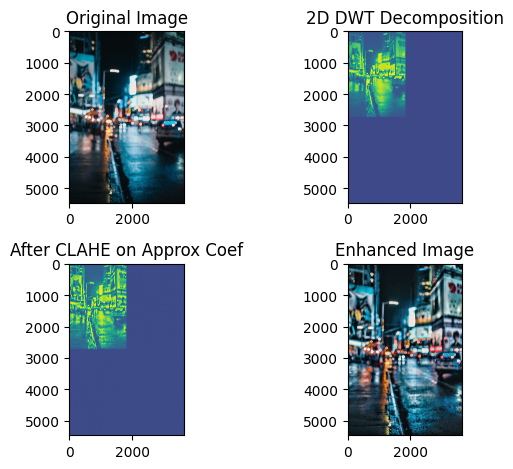

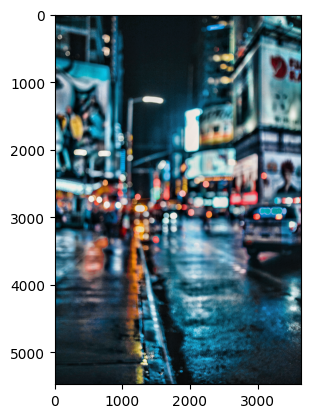

In [ ]:
from pathlib import Path
import numpy as np
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
import cv2
import pywt
from skimage.metrics import structural_similarity
import time
import warnings
warnings.filterwarnings("ignore")

# main function
def image_enhancement(input_image):
    # read the image
    img_path = Path(input_image)
    img = skimage.io.imread(img_path)

    # normalize the image for faster computation
    img = img/255.0

    # color space transform (RGB to HSV color space)
    # HSV stands for 'Hue', 'Saturation', and 'Value'
    hsv_img = rgb2hsv(img)
    h = hsv_img[:, :, 0]
    s = hsv_img[:, :, 1]
    v = hsv_img[:, :, 2]

    # decompose the 'Value' part of HSV by applying the 2D Discrete Wavelet Transform into it 
    # using 
    v_dwt = pywt.dwt2(v, 'haar')

    cA, (cH, cV, cD) = v_dwt

    # get the height and width of cA
    h_cA, w_cA = cA.shape

    # create matrix to store 2D DWT result
    v_dwt_matrix = np.zeros((2*h_cA, 2*w_cA), dtype=float)
    h_vwt, w_vwt = v_dwt_matrix.shape

    # store the result of 2D DWT to the created matrix
    v_dwt_matrix[:h_cA, :w_cA] = np.copy(cA)
    v_dwt_matrix[:h_cA, w_cA:w_vwt] = np.copy(cH)
    v_dwt_matrix[h_cA: h_vwt, :w_cA] = np.copy(cV)
    v_dwt_matrix[h_cA: h_vwt, w_cA:w_vwt] = np.copy(cD)

    # take the minimum and maximum values of cA
    min_cA = np.min(cA)
    max_cA = np.max(cA)

    # apply CLAHE to cA
    cA2 = cA/max_cA
    new_cA = clahe_(cA2, 16)/255.0
    new_cA = new_cA*(max_cA - min_cA)

    # create matrix again to store newly created cA, as well as cH, cV, cD 
    v_dwt_matrix_new = np.zeros(v_dwt_matrix.shape, dtype=float)
    v_dwt_matrix_new[:h_cA, :w_cA] = np.copy(new_cA)
    v_dwt_matrix_new[:h_cA, w_cA:w_vwt] = np.copy(cH)
    v_dwt_matrix_new[h_cA: h_vwt, :w_cA] = np.copy(cV)
    v_dwt_matrix_new[h_cA: h_vwt, w_cA:w_vwt] = np.copy(cD)

    # apply Inverse Discrete Wavelet Transform to convert it back to 'Value' part of HSV
    v_idwt = pywt.idwt2((new_cA, (cH, cV, cD)), 'haar')

    # apply CLAHE to 'Saturation' part of HSV
    s_enhanced = clahe_(s, 16)/255.0

    # rearrange the HSV
    height, width = h.shape
    enhanced_image = np.zeros((height, width, 3), dtype=float)
    enhanced_image[:, :, 0] = h
    enhanced_image[:, :, 1] = s_enhanced
    enhanced_image[:height, :width, 2] = np.copy(v_idwt[:height, :width])

    # convert back from HSV to RGB
    rgb_image_idwt_hsv = hsv2rgb(enhanced_image)

    [mse_hsv_r, psnr_hsv_r] = mse_(img[:, :, 0], rgb_image_idwt_hsv[:, :, 0])
    [mse_hsv_g, psnr_hsv_g] = mse_(img[:, :, 1], rgb_image_idwt_hsv[:, :, 1])
    [mse_hsv_b, psnr_hsv_b] = mse_(img[:, :, 2], rgb_image_idwt_hsv[:, :, 2])

    # show similarity measurement
    print('Similarity Measurement using tileGridSize', 16, 'x', 16)
    print(f'MSE_R: {mse_hsv_r:.4f}, MSE_G: {mse_hsv_g:.4f}, MSE_B: {mse_hsv_b:.4f}')
    print(f'PSNR_R: {psnr_hsv_r:.4f}, PSNR_G: {psnr_hsv_g:.4f}, PSNR_B: {psnr_hsv_b:.4f}')
    print("Time elapsed: %.4f seconds" % (time.time() - start_time))
    print(" ")

    # visualize the original image and its transformed ones
    out_name = 'tileGridSize_' + str(16) + 'x' + str(16) + '_out.jpg'
    detailed_out_name = '(detailed)tileGridSize_' + str(16) + 'x' + str(16) + '_out.jpg'
    
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(222)
    plt.imshow(v_dwt_matrix)
    plt.title('2D DWT Decomposition')

    plt.subplot(223)
    plt.imshow(v_dwt_matrix_new)
    plt.title('After CLAHE on Approx Coef')

    plt.subplot(224)
    plt.imshow(rgb_image_idwt_hsv)
    plt.title('Enhanced Image')

    plt.savefig(detailed_out_name)
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(.1)
    plt.close()

    plt.imshow(rgb_image_idwt_hsv)
    plt.savefig(out_name)

    return

# RGB to HSV function
def rgb2hsv(image):
    # split each part of RGB into 3 channels
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]
    height, width = red_channel.shape

    # find maximum value of each element accross all channels then calculate its differences
    c_max = np.maximum(red_channel, np.maximum(green_channel, blue_channel))
    c_min = np.minimum(red_channel, np.minimum(green_channel, blue_channel)) 
    difference = c_max - c_min

    # create matrices of zeros for storing the values of 'Saturation' and 'Hue'
    s_saturation = np.zeros((height, width), dtype=float)
    h_hue = np.zeros((height, width), dtype=float)

    # for each element, do calculation and assignments to certain element of certain matrices based on its condition
    for i in range(height):
        for j in range(width):
            if c_max[i, j] != 0:
                s_saturation[i, j] = difference[i, j]/c_max[i, j]
            if difference[i, j] != 0:
                if c_max[i, j] == red_channel[i, j]:
                    h_hue[i, j] = 60 * (((green_channel[i, j] - blue_channel[i, j]) / difference[i, j]) % 6)
                elif c_max[i, j] == green_channel[i, j]:
                    h_hue[i, j] = 60 *(((blue_channel[i, j] - red_channel[i, j]) / difference[i, j]) + 2)
                else:
                    h_hue[i, j] = 60 * (((red_channel[i, j] - green_channel[i, j]) / difference[i, j]) + 4)

    # set 'Value' part of HSV to c_max
    v_luminannce = c_max

    # arrange the HSV matrices
    hsv_image = np.zeros((height, width, 3), dtype=float)
    hsv_image[:, :, 0] = h_hue/360
    hsv_image[:, :, 1] = s_saturation
    hsv_image[:, :, 2] = v_luminannce

    return hsv_image

# HSV to RGB function
def hsv2rgb(hsv_image):
    h = hsv_image[:, :, 0]
    s = hsv_image[:, :, 1]
    v = hsv_image[:, :, 2]
    height, width = h.shape

    h = h * 360
    c = v * s # chroma
    m = v - c # rgb component with smallest value
    x = c * (1 - abs((h/60) % 2 - 1)) # an intermediate value used for computing the RGB model

    red_channel = np.zeros((height, width), dtype=float)
    green_channel = np.zeros((height, width), dtype=float)
    blue_channel = np.zeros((height, width), dtype=float)

    for i in range(height):
        for j in range(width):
            if 0 <= h[i, j] < 60:
                red_channel[i, j] = c[i, j]
                green_channel[i, j] = x[i, j]
                blue_channel[i, j] = 0
            if 60 <= h[i, j] < 120:
                red_channel[i, j] = x[i, j]
                green_channel[i, j] = c[i, j]
                blue_channel[i, j] = 0
            if 120 <= h[i, j] < 180:
                red_channel[i, j] = 0
                green_channel[i, j] = c[i, j]
                blue_channel[i, j] = x[i, j]
            if 180 <= h[i, j] < 240:
                red_channel[i, j] = 0
                green_channel[i, j] = x[i, j]
                blue_channel[i, j] = c[i, j]
            if 240 <= h[i, j] < 300:
                red_channel[i, j] = x[i, j]
                green_channel[i, j] = 0
                blue_channel[i, j] = c[i, j]
            if 300 <= h[i, j] < 360:
                red_channel[i, j] = c[i, j]
                green_channel[i, j] = 0
                blue_channel[i, j] = x[i, j]

    red_channel = red_channel + m
    green_channel = green_channel + m
    blue_channel = blue_channel + m
    image = np.zeros((height, width, 3), dtype=float)

    image[:, :, 0] = red_channel
    image[:, :, 1] = green_channel
    image[:, :, 2] = blue_channel

    return image

# CLAHE function
def clahe_(image, tile_grid_size):
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(tile_grid_size, tile_grid_size))
    clahe_image = clahe.apply((image*255).astype(np.uint8))

    return clahe_image

# MSE & PSNR function
def mse_(enhanced_img, input_img):
    enhanced_img = (enhanced_img * 255).astype('int')
    input_img = (input_img * 255).astype('int')
    height, width = enhanced_img.shape
    diff = enhanced_img - input_img
    sqr_diff = np.square(diff)
    sum_square = np.sum(sqr_diff)
    error = sum_square / (height * width)
    max_val = np.max(enhanced_img)
    psnr = 10*np.log10((max_val**2) / error)

    return [error, psnr]


if __name__ == '__main__':
    start_time = time.time()    
    image_enhancement('/pexels-guilherme-rossi-1668928.jpg')